In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # For progress tracking

In [30]:

# Define the folder path
folder_path = r"C:\Users\lsrin\Downloads\ResearchProject\dataset\Images"

# Define image size
IMG_SIZE = (224, 224)  # Resize all images to 224x224

# Function to load and preprocess images
def load_and_preprocess_images(folder_path):
    images = []
    filenames = []
    
    for file in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file)
        
        # Load image using OpenCV
        image = cv2.imread(file_path)
        if image is None:
            print(f"Error loading: {file}")
            continue
        
        # Resize image
        image = cv2.resize(image, IMG_SIZE)
        
        # Normalize image (convert to 0-1 range)
        image = image.astype(np.float32) / 255.0
        
        images.append(image)
        filenames.append(file)
    
    return np.array(images), filenames

# Run the function
images, filenames = load_and_preprocess_images(folder_path)

print(f"Loaded {len(images)} images successfully!")


100%|██████████| 1457/1457 [01:48<00:00, 13.45it/s]


✅ Loaded 1457 images successfully!


## Image Preprocessing Steps
### step 1: Resizing
Resize images to a uniform shape (e.g., 224x224 for CNNs like ResNet or 128x128 for a lightweight model).

## Noise Reduction & Smoothing
Apply Gaussian Blur or Median Filtering to remove noise while keeping skin texture.

## Color Space Conversion
Convert the image to HSV or YCrCb to highlight red (pimple) and dark (spot) regions.

## Contrast Enhancement (CLAHE)
Improves visibility of dark spots and pimples.

## Thresholding & Edge Detection
Thresholding: Helps segment pimples (red regions) and dark spots.
Canny Edge Detection: Finds clear boundaries of acne.

## Data Augmentation (Optional)
Use horizontal flipping, brightness adjustment, and rotation to increase dataset variety.

In [36]:
def preprocess_image(image):
    # Convert to HSV and LAB color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Apply CLAHE for contrast enhancement
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Apply noise removal
    image_denoised = cv2.medianBlur(image_clahe, 5)

    # Convert to grayscale and detect edges (for feature extraction)
    gray = cv2.cvtColor(image_denoised, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 30, 100)

    return image_denoised, edges

# Apply preprocessing to all images
preprocessed_images = []
edge_maps = []

for img in tqdm(images):
    img_denoised, img_edges = preprocess_image((img * 255).astype(np.uint8))  # Convert back to 0-255 for OpenCV
    preprocessed_images.append(img_denoised)
    edge_maps.append(img_edges)

print(f" Preprocessed {len(preprocessed_images)} images!")


100%|██████████| 1457/1457 [00:05<00:00, 255.05it/s]

✅ Preprocessed 1457 images!


## step 2: save the processed data

In [39]:
output_folder = r"C:\Users\lsrin\Downloads\ResearchProject\dataset\Preprocessed"

# Create output folder if not exists
#os.makedirs(output_folder, exist_ok=True)

for i, img in enumerate(preprocessed_images):
    save_path = os.path.join(output_folder, filenames[i])
    cv2.imwrite(save_path, img)

print(f" Saved preprocessed images in {output_folder}")


✅ Saved preprocessed images in C:\Users\lsrin\Downloads\ResearchProject\dataset\Preprocessed


In [74]:
import numpy as np
import matplotlib.pyplot as plt

## USING PRETRAINED MODEL

In [113]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

In [85]:
# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 10

# Define pretrained models
pretrained_models = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "MobileNetV2": MobileNetV2,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0
}

In [119]:
def load_preprocessed_images(folder_path):
    images, labels = [], []
    for file in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file)
        image = cv2.imread(file_path)
        if image is None:
            continue
        image = cv2.resize(image, IMG_SIZE)
        image = image.astype(np.float32) / 255.0
        images.append(image)
        
        # Extract numeric severity   level from filenames like "level1_6.jpg"
        label = ''.join([c for c in file if c.isdigit()])  # Extract digits from filename
        if label:
            labels.append(int(label[0]))  # Use the first digit as severity level
        else:
            continue  # Skip files that don't contain a valid severity level

    return np.array(images), np.array(labels)

# Extract features using a pretrained model
def extract_features(model_name, images):
    base_model = pretrained_models[model_name](weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))
    features = model.predict(images)
    return features

In [121]:
# Load dataset
preprocessed_folder = r"C:\Users\lsrin\Downloads\ResearchProject\dataset\Preprocessed"
X, y = load_preprocessed_images(preprocessed_folder)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, NUM_CLASSES)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


100%|██████████| 1457/1457 [00:02<00:00, 550.36it/s]


In [123]:
# Train classifiers and visualize results
history_dict = {}
for model_name in pretrained_models.keys():
    print(f'Training classifier using {model_name} features...')
    X_train_features = extract_features(model_name, X_train)
    X_val_features = extract_features(model_name, X_val)
    
    # Build classifier
    classifier = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_features.shape[1],)),
        Dense(128, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    classifier.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    history = classifier.fit(X_train_features, y_train, validation_data=(X_val_features, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)
    history_dict[model_name] = history.history
    
    print(f'Training completed for {model_name}')

Training classifier using VGG16 features...
37/37 ━━━━━━━━━━━━━━━━━━━━ 1351s 37s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 10s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.4125 - loss: 2.0073 - val_accuracy: 0.4349 - val_loss: 1.4459
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5687 - loss: 0.9897 - val_accuracy: 0.4897 - val_loss: 1.6279
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.7923 - loss: 0.5422 - val_accuracy: 0.5411 - val_loss: 0.9979
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8365 - loss: 0.4117 - val_accuracy: 0.6164 - val_loss: 0.9073
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8392 - loss: 0.3650 - val_accuracy: 0.6233 - val_loss: 0.9497
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9228 - loss: 0.2300 - val_accuracy: 0.6644 - val_loss: 0.8996
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9728 - loss: 0.1342 - val_accuracy: 0.6575 - val_loss: 0.8865
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9742 - loss: 0.1110 - val_accuracy: 0

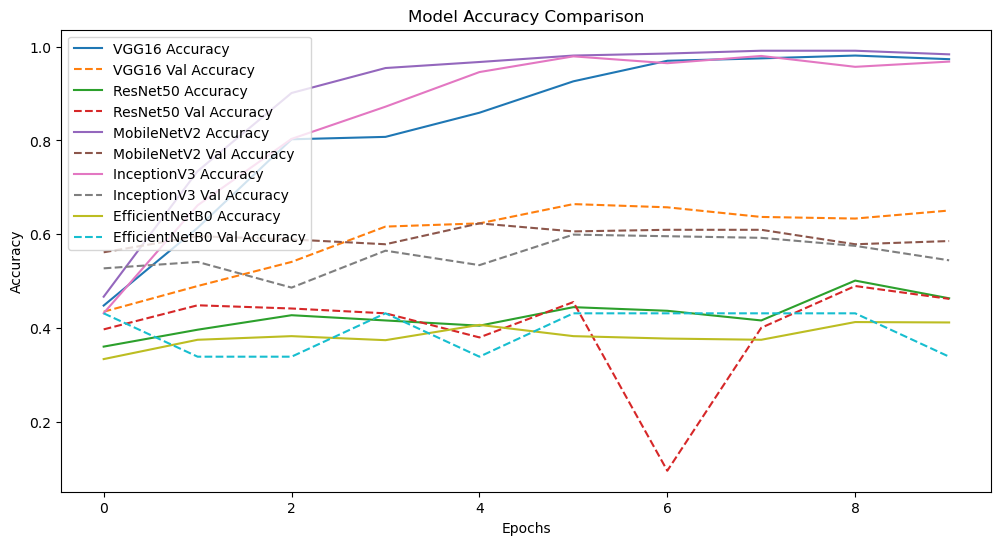

In [125]:
# Plot training results
def plot_training_results(history_dict):
    plt.figure(figsize=(12, 6))
    for model_name, history in history_dict.items():
        plt.plot(history['accuracy'], label=f'{model_name} Accuracy')
        plt.plot(history['val_accuracy'], label=f'{model_name} Val Accuracy', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy Comparison')
    plt.show()

plot_training_results(history_dict)

In [127]:
# Predict severity level for a new image
def predict_severity(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    
    predictions = {}
    for model_name in pretrained_models.keys():
        features = extract_features(model_name, image)
        classifier = Sequential([
            Dense(256, activation='relu', input_shape=(features.shape[1],)),
            Dense(128, activation='relu'),
            Dense(NUM_CLASSES, activation='softmax')
        ])
      
        classifier.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        prediction = classifier.predict(features)
        predicted_class = np.argmax(prediction)
        severity_level = label_encoder.inverse_transform([predicted_class])[0]
        predictions[model_name] = severity_level
    
    return predictions

# Example usage
image_path = r"C:\Users\lsrin\Downloads\Acne (face) images\acne-077-v2.jpg"
print(predict_severity(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
{'VGG16': 0, 'ResNet50': 1, 'MobileNetV2': 2, 'InceptionV3': 3, 'EfficientNetB0': 2}


In [131]:
# Example usage
image_path = r"C:\Users\lsrin\Downloads\ResearchProject\dataset\Images\levle3_94.jpg"
print(predict_severity(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\Users\lsrin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
{'VGG16': 0, 'ResNet50': 0, 'MobileNetV2': 3, 'InceptionV3': 2, 'EfficientNetB0': 2}


# Multi model using ML+DEEP Learning (customized CNN)